In [3]:
import sys
sys.path.insert(0, '../../_libs/')
import NEMO_tools as Nts

In [4]:
import glob
import datetime
import scipy.io
import scipy.signal
import numpy as np
import netCDF4 as nc
import cartopy.feature
import cartopy.crs as ccrs # ccrs
#import NEMO_tools as Nts
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
% matplotlib inline

In [5]:
RB=[0.25, 0.41, 0.88]    # Royal blue
AM=[0.90, 0.17, 0.31]    # Amathran

In [6]:
def seasonal_decomp3d(data_in, method=0):
    '''
    =======================================================================
    Remove the seasonal cycle from 1D data
                            ----- created on 2015/06/15, Yingkai (Kyle) Sha
    -----------------------------------------------------------------------
        data = seasonal_decomp(...)
    -----------------------------------------------------------------------
    Input:
            data: Time should be the first dim.
            method: removal done by anomaly (=0) or normalize (=1)
    ======================================================================= 
    '''
    data = np.copy(data_in)
    for mon in range(12):
        temp_mean = np.nanmean(data[mon:len(data):12, :, :], 0)
        if method == 0:
            data[mon:len(data):12, :, :] = data[mon:len(data):12, :, :]-temp_mean
        if method == 1:
            temp_std = np.nanstd(data[mon:len(data):12, :, :], 0)
            data[mon:len(data):12, :, :] = (data[mon:len(data):12, :, :]-temp_mean)/temp_std
    return data

# Calculate u, v anomaly

In [7]:
u_names = sorted(glob.glob('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/GDPS/u10*monmean*nc'))
v_names = sorted(glob.glob('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/GDPS/v10*monmean*nc'))

In [8]:
u_obj = nc.Dataset(u_names[0])
x = u_obj.variables['LON'][:]
y = u_obj.variables['LAT'][:]
lon, lat = np.meshgrid(x, y)

In [9]:
my_x = np.linspace(0, 360, 180)
my_y = np.linspace(60, 90, 15)
mylon, mylat = np.meshgrid(my_x, my_y)

In [10]:
mylon.shape

(15, 180)

In [11]:
u_wind = np.empty([144, 15, 180])
v_wind = np.empty([144, 15, 180])

In [9]:
for j in range(len(u_names)):
    u_obj = nc.Dataset(u_names[j])
    u = u_obj.variables['u_wind'][:]
    for i in range(12):
        u_wind[j*12+i, :, :] = Nts.reporj_NEMOgrid(lon, lat, u[i, :, :], mylon, mylat, method='linear')

In [10]:
for j in range(len(v_names)):
    v_obj = nc.Dataset(v_names[j])
    v = v_obj.variables['v_wind'][:]
    for i in range(12):
        v_wind[j*12+i, :, :] = Nts.reporj_NEMOgrid(lon, lat, v[i, :, :], mylon, mylat, method='linear')

In [11]:
u_wind.shape

(144, 15, 180)

In [12]:
u_anom = seasonal_decomp3d(u_wind, method=1)
v_anom = seasonal_decomp3d(v_wind, method=1)

/home/yingkai/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/yingkai/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1136: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


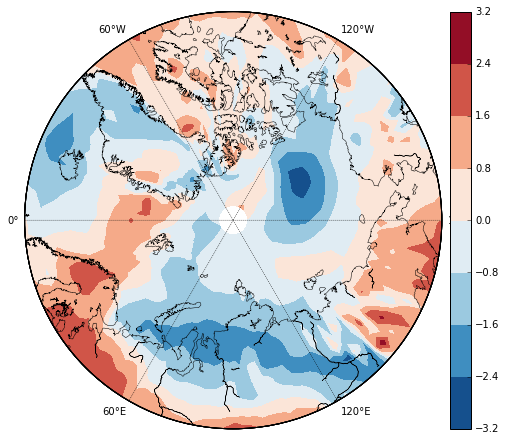

In [82]:
fig = plt.figure(figsize=(8, 8)); ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=90, round=True, ax=ax)
proj.drawparallels(np.arange(0, 90, 20), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0.5)
proj.drawcoastlines(linewidth=0.5, color='k')
x, y = proj(mylon, mylat)
CS = proj.contourf(x, y, u_anom[0, :, :], cmap=plt.cm.RdBu_r)
proj.colorbar(CS)

In [15]:
save_var = {'lon': mylon, 'lat': mylat, 'u': u_anom, 'v': v_anom}
scipy.io.savemat('_data/Temp/uv10.mat', mdict=save_var)

# Calculate dissolved Barium anomaly

In [12]:
Ba_x = np.linspace(0, 360, 180)
Ba_y = np.linspace(60, 90, 15)
Balon, Balat = np.meshgrid(Ba_x, Ba_y)

In [13]:
FName = '/ocean/yingkai/GEOTRACES/Simulations/SPIN06_SET02_1m_20020101_20131231_ptrc_T.nc'
ptrc_obj1 = nc.Dataset(FName)
nav_lon = ptrc_obj1.variables['nav_lon'][:]
nav_lat = ptrc_obj1.variables['nav_lat'][:]

In [14]:
nav_lon[nav_lon<0]=nav_lon[nav_lon<0]+360

In [15]:
Ba = np.empty([144, 15, 180])

In [16]:
for i in range(144):
    temp = ptrc_obj1.variables['Ba'][i, 0, :, :]; temp[temp==0]=np.nan
    Ba[i, :, :] = Nts.reporj_NEMOgrid(nav_lon, nav_lat, temp, Balon, Balat, method='linear')

In [17]:
Ba_anom = seasonal_decomp3d(Ba, method=1)

/home/yingkai/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/home/yingkai/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


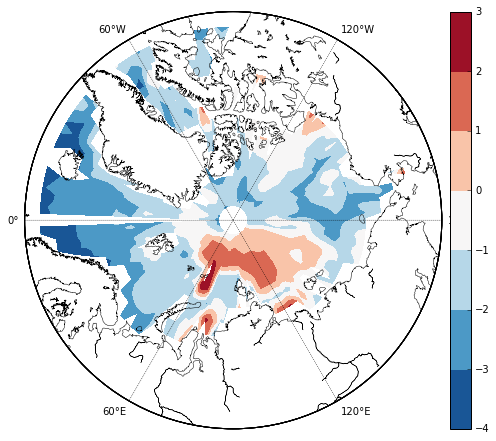

In [18]:
fig = plt.figure(figsize=(8, 8)); ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=90, round=True, ax=ax)
proj.drawparallels(np.arange(0, 90, 20), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0.5)
proj.drawcoastlines(linewidth=0.5, color='k')
x, y = proj(Balon, Balat)
CS = proj.contourf(x, y, Ba_anom[0, :, :], cmap=plt.cm.RdBu_r)
proj.colorbar(CS)

In [19]:
Ba_anom.shape

(144, 15, 180)

In [21]:
save_var = {'Balon': Balon, 'Balat': Balat, 'Ba_anom': Ba_anom, 'Ba': Ba}
scipy.io.savemat('../../_data/Temp/Ba.mat', mdict=save_var)

# Singular value decompsition

In [102]:
def draw_smode(lon, lat, EOFs, clevs, num, ax):
    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=90, round=True, ax=ax)
    proj.drawparallels(np.arange(0, 90, 20), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0.5)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(lon, lat)
    CS = proj.contourf(x, y, EOFs[num, :, :], clevs, cmap=plt.cm.RdBu_r, extend='both')
    #proj.contour(x, y, EOFs[num, :, :], clevs, colors='gray', linewidths=1.5)
    #props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    #ax.text(0.75, 0.90, "Exp. var.: %.2f"%expvar[num], transform=ax.transAxes, \
        #fontsize=10, verticalalignment='top', bbox=props)
    return CS

In [112]:
def draw_wind(lon, lat, u, v, ax):
    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=90, round=True, ax=ax)
    proj.drawparallels(np.arange(0, 90, 20), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
    proj.drawmeridians(np.arange(0, 360, 60), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0.5)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(lon, lat)
    proj.quiver(x, y, u, v)

In [96]:
lev = np.array([-2.25, -1.75, -1.25, -0.75, -0.25, 0.25, 0.75, 1.25, 1.75, 2.25])/50

In [97]:
MAT = scipy.io.loadmat('_data/Temp/SVD_Result.mat')

EBa = MAT['EBa'][:]
EU = MAT['EU'][:]
EV = MAT['EV'][:]
expvar = np.squeeze(MAT['expvar'][:])

PCBa = MAT['PCBa'][:]
PCWind = MAT['PCWind'][:]

In [104]:
EU.shape

(10, 15, 180)

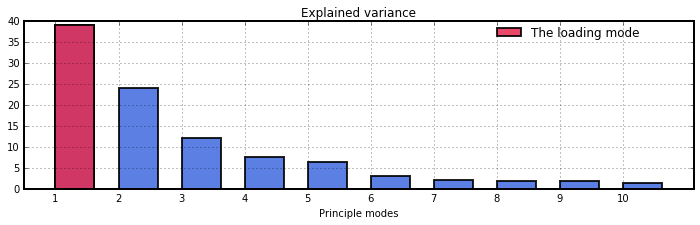

In [99]:
fig=plt.figure(figsize=(12, 3))
ax=plt.gca(); ax.grid(); ax.set_xlim(0.5, 11.118)
ax.bar(np.arange(1, 11), expvar, width=0.618, lw=2, alpha=0.85, color=RB)
ax.bar(1, expvar[0], width=0.618, lw=2, alpha=0.85, color=AM, label='The loading mode')
ax.set_xticks(np.arange(1, 11))
LG = ax.legend(numpoints=1, bbox_to_anchor=(0.7, 1), loc=2, borderaxespad=0.); LG.draw_frame(False)
[i.set_linewidth(2) for i in ax.spines.itervalues()]
ax.set_xlabel('Principle modes')
ax.set_title('Explained variance', fontsize=12)

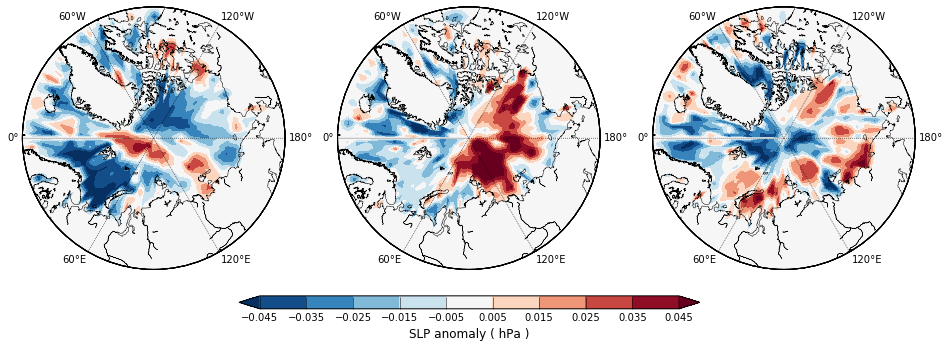

In [100]:
fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=1, rowspan=1)
ax3 = plt.subplot2grid((1, 3), (0, 2), colspan=1, rowspan=1)
draw_smode(Balon, Balat, EBa, lev, 0, ax1, edge=0)
draw_smode(Balon, Balat, EBa, lev, 1, ax2, edge=0)
CS = draw_smode(Balon, Balat, EBa, lev, 2, ax3, edge=0)

cax  = fig.add_axes([0.313, 0.315, 0.4, 0.015])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('SLP anomaly ( hPa )', fontsize=12)
CBar.ax.tick_params(axis='x', length=12)
CBar.set_ticks(lev)

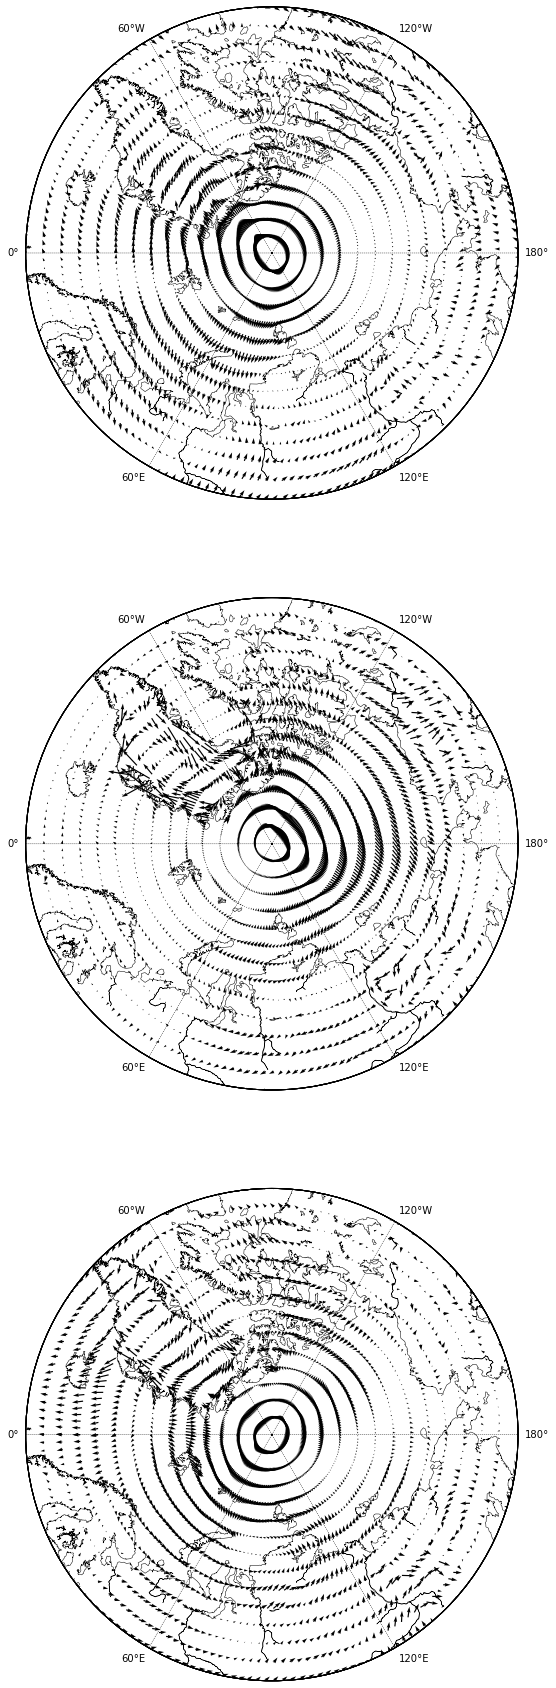

In [118]:
fig = plt.figure(figsize=(10, 30))
ax1 = plt.subplot2grid((3, 1), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((3, 1), (1, 0), colspan=1, rowspan=1)
ax3 = plt.subplot2grid((3, 1), (2, 0), colspan=1, rowspan=1)
draw_wind(mylon, mylat, EU[0, :, :], EV[0, :, :], ax1)
draw_wind(mylon, mylat, EU[1, :, :], EV[1, :, :], ax2)
draw_wind(mylon, mylat, EU[2, :, :], EV[2, :, :], ax3)

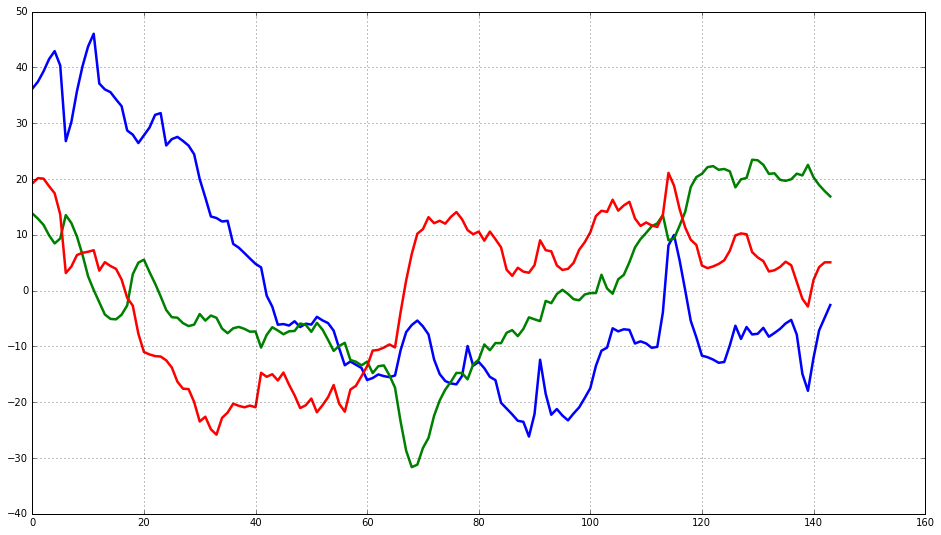

In [122]:
fig = plt.figure(figsize=(16, 9))
plt.plot(PCBa[0:3, :].T, lw=2.5); plt.grid()

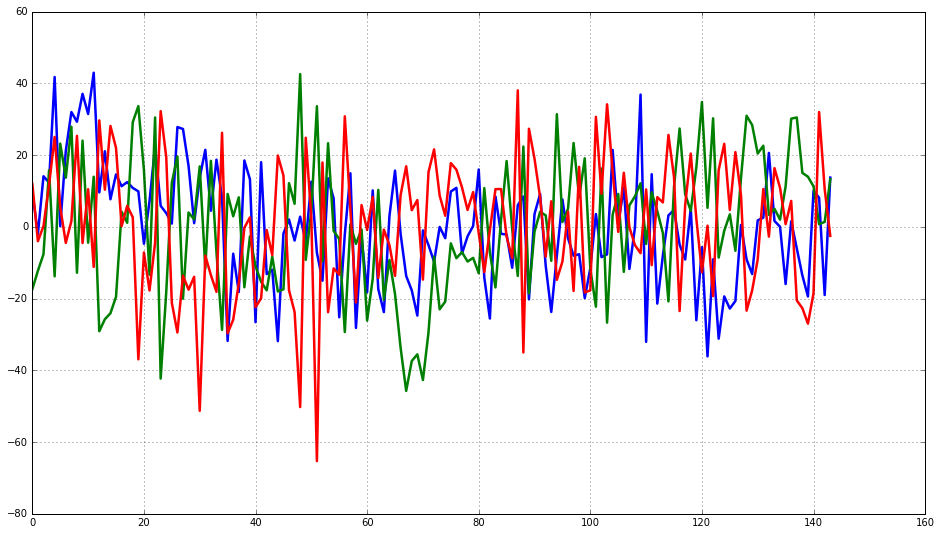

In [123]:
fig = plt.figure(figsize=(16, 9))
plt.plot(PCWind[0:3, :].T, lw=2.5); plt.grid()